In [65]:
# RNN on sine wave, using bp on weight matrix, enforce Dale's law
import sys
sys.path.append("../../model")
import numpy as np
from rnn_wt import RNN
import matplotlib.pyplot as plt
import json
import torch
import seaborn as sns

## Loading Trained Weights

In [66]:
num_nodes = 16
filedir = "../weights/"
filename = "SIN_wt_" + str(num_nodes) + "_nodes.json"
filepath = filedir + filename
with open(filepath) as f:
    weight_history = json.load(f)

In [67]:
weight_history.keys()

dict_keys(['trained gain', 'trained shift', 'trained weights', 'connectivity matrix', 'input weights', 'output weights', 'losses', 'init_weight'])

In [68]:
gains = np.array(weight_history['trained gain'])
shifts = np.array(weight_history['trained shift'])
weight_matrix = np.array(weight_history['trained weights'])
connectivity_matrix = np.array(weight_history['connectivity matrix'])
input_weight_matrix = np.array(weight_history['input weights'])
output_weight_matrix = np.array(weight_history['output weights'])
losses = np.array(weight_history['losses'])

# test oja
# weight_sums = np.array(weight_history['weight_sums'])
# gain_changes = np.array(weight_history['gain_changes'])

In [69]:
gains

array([[ 0.75880563],
       [ 0.8849088 ],
       [-0.87728155],
       [-0.86778724],
       [-1.44087601],
       [ 1.23225307],
       [-0.25417987],
       [ 1.39984393],
       [-0.78191167],
       [-0.43750897],
       [ 0.09542508],
       [ 0.92145008],
       [ 0.0607502 ],
       [ 0.21112475],
       [ 0.01652757],
       [ 0.17718773]])

In [70]:
input_weight_matrix

array([[ 2.05117344,  0.585662  ,  0.42952614, -0.6069984 ,  0.10622272,
        -1.52568032,  0.79502609, -0.37443832,  0.1340482 ,  1.20205486,
         0.28474811,  0.26246745,  0.2764993 , -0.7332716 ,  0.83600472,
         1.54335911]])

In [71]:
output_weight_matrix

array([[ 0.06977443, -0.40571227, -0.00333817, -0.1736734 , -0.15545088,
         0.14995113,  0.28085304,  0.07631676, -0.34719485,  0.16533606,
         0.75771428,  0.20614616, -0.16364504,  0.01279711, -0.18139928,
        -0.21694217]])

<Axes: >

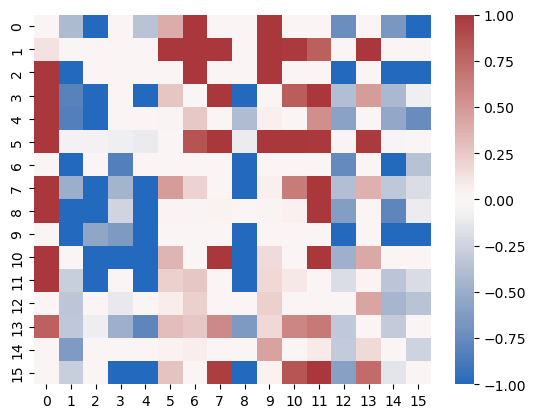

In [72]:
sns.heatmap(weight_matrix, vmax=1, vmin=-1, cmap='vlag')

In [73]:
np.sum(weight_matrix)

-12.432187887257896

<Axes: >

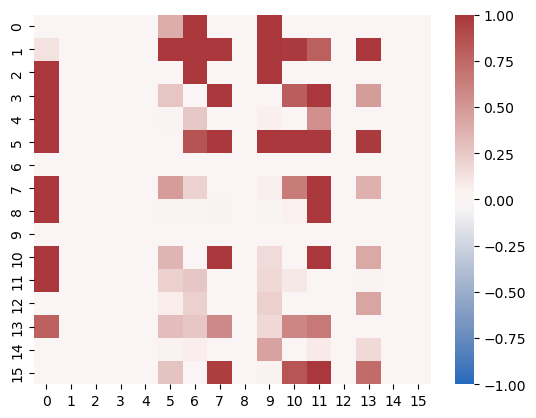

In [74]:
excite_weights = weight_matrix * (weight_matrix > 0)
sns.heatmap(excite_weights, vmax=1, vmin=-1, cmap='vlag')

In [75]:
np.sum(excite_weights)

110.03817557787988

In [76]:
# estimate oja's alpha
1 / np.linalg.norm(excite_weights, None)**2

0.0020619686030567

## Defining Network

In [77]:
time_constant = 100 #ms
timestep = 10 #ms
time = 3000 #ms
num_inputs = 1
num_nodes = 16
init_activations = np.zeros((num_nodes, 1))

network = RNN(weight_matrix, connectivity_matrix, init_activations, gains, shifts, input_weight_matrix, output_weight_matrix, 
                time_constant = time_constant, timestep = timestep)

100%|██████████| 300/300 [00:00<00:00, 27956.44it/s]


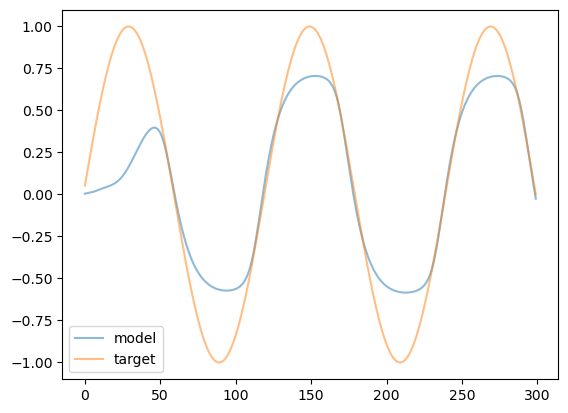

In [78]:
time_points = np.arange(300).reshape(-1, 1)
# inputs = (1 + np.sin(time_points/60*np.pi))/2
# targets = (1 + np.sin((time_points+1)/60*np.pi))/2
inputs = np.sin(time_points/60*np.pi)
targets = np.sin((time_points+1)/60*np.pi)
# inputs = np.sin(time_points/60*np.pi) / 4 + 0.5
# targets = np.sin((time_points+1)/60*np.pi) / 4 + 0.5
inputs = inputs.reshape(-1, 1)
targets = targets.reshape(-1, 1)

outputs, activations = network.simulate(time, torch.tensor(inputs).float())
fig, ax = plt.subplots()
plt.plot(time_points, outputs.detach().numpy(), alpha=0.5, label='model')
# plt.plot(time_points, inputs)
plt.plot(time_points, targets, alpha=0.5, label='target')
# plt.ylim([0,1])
plt.legend()
# plt.savefig("fig/sin_oja_train.png")

100%|██████████| 300/300 [00:00<00:00, 34598.86it/s]


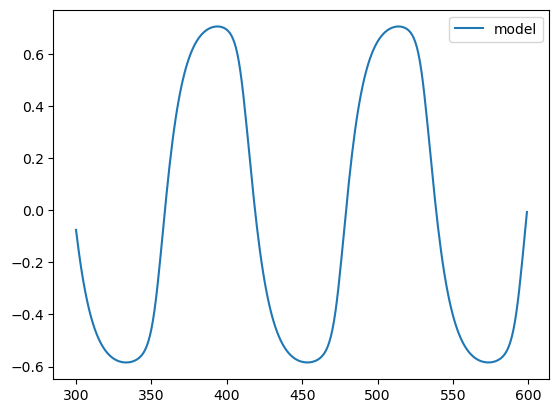

In [79]:
time_pred = 3000

time_points_pred = np.arange(300,600).reshape(-1, 1)
# inputs_pred = (1 + np.sin(time_points_pred/60*np.pi))/2
inputs_pred = np.sin(time_points_pred/60*np.pi)
# inputs_pred = np.sin(time_points_pred/60*np.pi) / 4 + 0.5

outputs_pred, activations_pred = network.simulate(time_pred, torch.tensor(inputs_pred).float())
fig, ax = plt.subplots()
plt.plot(time_points_pred, outputs_pred.detach().numpy(), label='model')
# plt.ylim([0,1])
plt.legend()
# plt.savefig("fig/sin_oja_pred.png")

(0.0, 0.5)

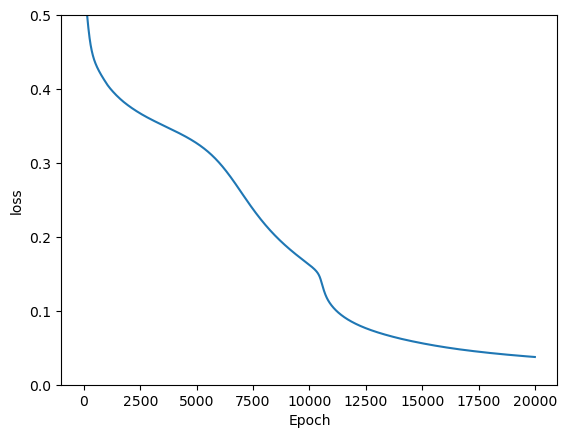

In [80]:
plt.plot(np.arange(len(losses)), losses)
plt.xlabel("Epoch")
plt.ylabel("loss")
plt.ylim([0,0.5])
# plt.savefig("fig/sin_oja_loss.png")

Text(50.722222222222214, 0.5, 'Node')

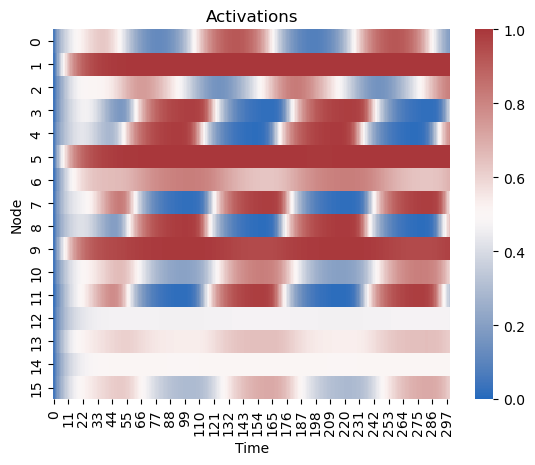

In [81]:
activations_t = activations.detach().numpy().T
sns.heatmap(activations_t, cmap='vlag', vmax=1, vmin=0)
plt.title('Activations')
plt.xlabel('Time')
plt.ylabel('Node')
# plt.savefig('fig/0221_SIN2_bphcppt_activations.png')